In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

N = 160
Noutputs = 2
f = lambda x: 3*np.sin(3*x[..., 0]) * np.exp(-0.04*x[..., 0]**2)
observation_index_points = np.sort(np.random.uniform(-1., 1., N))[..., np.newaxis].astype(np.float64)
observations = np.random.normal(f(observation_index_points), .005).astype(np.float64)[:,None]
observation_index_points = np.c_[observation_index_points,np.zeros(len(observation_index_points))] #location
observation_index_points = np.c_[observation_index_points,np.zeros(len(observation_index_points))] #sensor number
observations[-60:,0]+=7*(observation_index_points[-60:,0]-observation_index_points[-60,0])
oldobs = observations.copy()
#observations[-100:,0]=oldobs[-100:,0]*3
#observation_index_points[-100:,-1]=1
observations[::3,0]=oldobs[::3,0]*3
observation_index_points[::3,-1]=1
movesel = (observation_index_points[:,-1]==1) & (observation_index_points[:,0]>0)
observation_index_points[movesel,1] = observation_index_points[movesel,0]

num_sparse = 8
sparse_index_points = np.linspace(-2., 2., num_sparse)[:, None]
scalinggpkernel = psd_kernels.ExponentiatedQuadratic(np.float64(2.0), np.float64(4.0))
scalinggpnoisevar = 1e-6
def joint_log_prob(index_points, scalingvalues, observations): 
    logprob = 0
    scaledobs = np.zeros([parallel,observations.shape[0]])
    for output in range(1,2):
        sel = np.where(index_points[:,-1]==output)[0]
        
        gprm = tfd.GaussianProcessRegressionModel(
            kernel=scalinggpkernel,
            index_points=index_points[sel,0:1],
            observation_index_points=sparse_index_points,
            observations=scalingvalues[:,output-1,:],
            observation_noise_variance=np.float64(scalinggpnoisevar))
        #print(scaledobs[:,sel].shape)
        #print((observations[sel,0]/tf.exp(gprm.mean())).shape)
        #print(gprm.mean())
        scaledobs[:,sel] = observations[sel,0]/tf.exp(gprm.mean())
        
        #k = psd_kernels.ExponentiatedQuadratic(np.float64(10.0),np.float64(1.0))
        gp_scalingvalues = tfd.GaussianProcess(
            kernel=scalinggpkernel,
            index_points=sparse_index_points, 
            observation_noise_variance=np.float64(scalinggpnoisevar))
        logprob += gp_scalingvalues.log_prob(scalingvalues[:,output-1,:])
    
    sel = np.where(index_points[:,-1]==0)[0]
    
    
    scaledobs[:,sel] = observations[sel,0]
    
    
    gpkernel = psd_kernels.ExponentiatedQuadratic(np.float64(10.0),np.float64(1.0))#,feature_ndims=2)
    gp = tfd.GaussianProcess(kernel=gpkernel,index_points=index_points[:,:-1], observation_noise_variance=np.float64(1e-4))
    logprob+= gp.log_prob(scaledobs)    
    return logprob, scaledobs

parallel = 256
init_scaling = 1*np.random.randn(parallel,Noutputs-1,num_sparse).astype(np.float64)
#init_scaling[:,observations[:,1]==0]=0
initial_chain_states = [
    init_scaling,
]
def unnormalized_log_posterior(scalingvalues):
    logprob, scaledobs = joint_log_prob(observation_index_points, scalingvalues, observations)
    return logprob

unnormalized_log_posterior(tf.constant(init_scaling))

<tf.Tensor: id=2318, shape=(256,), dtype=float64, numpy=
array([-3.39625938e+06, -2.91527432e+06, -2.01112888e+06, -1.85386439e+06,
       -4.22953932e+06, -5.56038993e+06, -6.87678901e+06, -1.62109548e+07,
       -3.30591007e+07, -5.98490605e+05, -1.50523636e+07, -6.73615532e+06,
       -1.78853251e+07, -1.56875952e+06, -7.70518239e+05, -1.46167414e+06,
       -1.48874250e+07, -4.69025043e+06, -1.19189650e+07, -1.12093942e+07,
       -1.00100962e+06, -3.80933578e+06, -1.37805058e+06, -1.02452738e+06,
       -2.99879036e+06, -3.96219956e+06, -2.75101295e+06, -3.40518404e+06,
       -1.76858471e+06, -5.88437911e+05, -1.42210542e+06, -1.61717435e+06,
       -1.12519627e+06, -2.93869043e+06, -1.59236164e+06, -7.49969509e+05,
       -2.69160060e+07, -3.87175788e+06, -2.05618520e+06, -1.42319107e+06,
       -4.25202181e+06, -3.04913566e+05, -1.31683088e+07, -2.19776901e+07,
       -5.13609819e+06, -3.75345250e+06, -3.98484037e+07, -2.53033023e+06,
       -1.72751120e+07, -1.62517008e+07, -2

In [3]:
num_results = 100
num_burnin_steps = 2000
kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            step_size=np.float64(0.02),
            num_leapfrog_steps=2)
kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=kernel,
    bijector=[tfp.bijectors.AffineLinearOperator(scale=tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(
                scalinggpkernel.matrix(sparse_index_points,
                                 sparse_index_points)
            + ((1e-4)**2) * tf.eye(num_sparse, dtype=np.float64))     ))]   )
kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8), target_accept_prob=np.float64(0.75))

from time import time

#@tf.function ##<=need to rewrite to make the code work with tensorflow!
def run_mcmc():
    [preds], kernel_results = tfp.mcmc.sample_chain(num_steps_between_results=5,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_states,
        kernel=kernel)
    return preds, kernel_results

start = time()
preds, kernel_results = run_mcmc()
print("Time: %0.2f" % (time()-start))
print("Acceptance rate: {}".format(
  np.mean(kernel_results.inner_results.inner_results.is_accepted)))

/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "
W0913 10:08:31.999984 140691203434240 deprecation.py:323] From /home/mike/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Time: 950.09
Acceptance rate: 0.760625


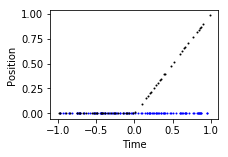

In [29]:
sel = observation_index_points[:,-1]==0
plt.figure(figsize=[3,2])
plt.scatter(observation_index_points[sel,0],observation_index_points[sel,1],1,color='b')
plt.scatter(observation_index_points[~sel,0],observation_index_points[~sel,1],1,color='k')
plt.xlabel('Time')
plt.ylabel('Position')
plt.savefig('twosensorgpsim.pdf',bbox_inches='tight')

In [5]:
preds.shape

TensorShape([100, 256, 1, 8])

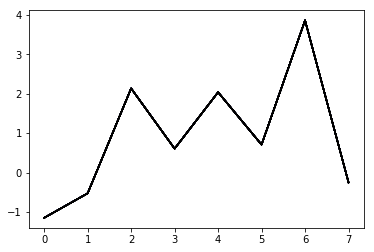

In [6]:
#plt.figure(figsize=[20,20])
plt.plot(preds.numpy()[0,0,0,:].T,'b-',markersize=1,alpha=1);
plt.plot(preds.numpy()[:,0,0,:].T,'k-',markersize=1,alpha=0.1);
plt.plot(preds.numpy()[-1,0,0,:].T,'k-',markersize=1,alpha=1);

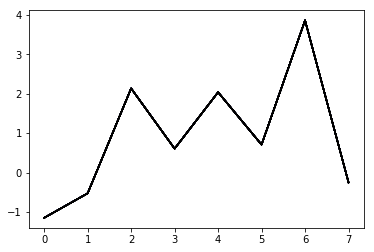

In [7]:
#plt.figure(figsize=[20,20])
plt.plot(preds.numpy()[0,0,0,:].T,'b-',markersize=1,alpha=1);
plt.plot(preds.numpy()[:,0,0,:].T,'k-',markersize=1,alpha=0.1);
plt.plot(preds.numpy()[-1,0,0,:].T,'k-',markersize=1,alpha=1);

In [8]:
preds.shape

TensorShape([100, 256, 1, 8])

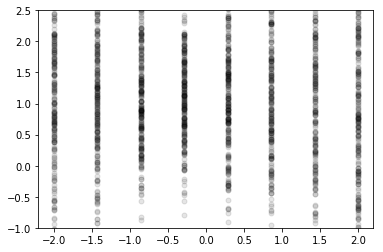

In [9]:
plt.ylim([-1,2.5])
plt.plot(sparse_index_points,preds.numpy()[-1,:,0,:].T,'k.',markersize=10,alpha=0.1);

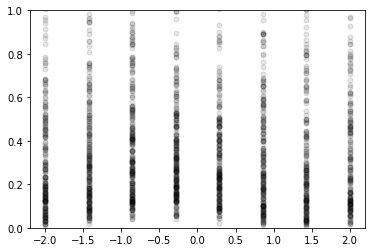

In [10]:
plt.ylim([0,1])
plt.plot(sparse_index_points, 1/np.exp(preds.numpy()[-1,:,0,:].T),'k.',markersize=10,alpha=0.1);

In [11]:
logprob, scaledobs = joint_log_prob(observation_index_points, preds[-1,:,:,:], observations)

In [12]:
np.median(logprob)

-598274.9335951246

In [13]:
keep=(logprob>np.max(logprob)-5e4)

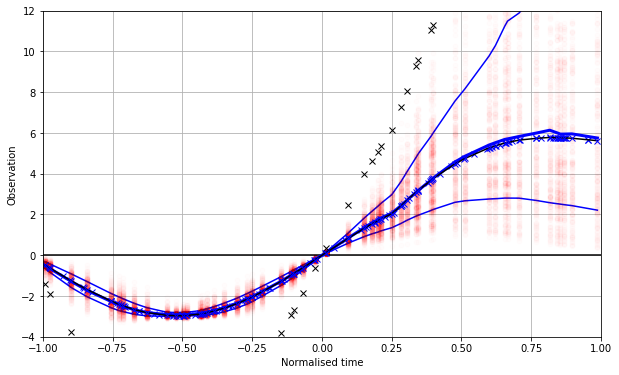

In [24]:
plt.figure(figsize=[10,6])
#plt.plot(observation_index_points[:,0], np.sort(scaledobs[keep,:],0)[1+int(np.sum(keep)*0.159),:],'b-');
#plt.plot(observation_index_points[:,0], np.sort(scaledobs[keep,:],0)[int(np.sum(keep)*0.841)-1,:],'b-');
#plt.plot(observation_index_points[:,0], np.sort(scaledobs,0)[1+int(len(scaledobs)*0.159),:],'b-');
#plt.plot(observation_index_points[:,0], np.sort(scaledobs,0)[int(len(scaledobs)*0.841)-1,:],'b-');

cis = [0.159,0.841]
sel = observation_index_points[:,-1]==1
plt.plot(observation_index_points[sel,0], np.sort(scaledobs[:,sel],0)[int(len(scaledobs)*cis[0]),:],'b-');
plt.plot(observation_index_points[sel,0], np.sort(scaledobs[:,sel],0)[int(len(scaledobs)*cis[1]),:],'b-');
plt.plot(observation_index_points[sel,0], scaledobs[:,sel].T,'r.',lw=3,alpha=0.01,markersize=10);
plt.plot(observation_index_points[sel,0], np.median(scaledobs[:,sel],0).T,'-b',lw=3);

for output,col in zip([0,1],['xb','xk']):
    sel = observation_index_points[:,-1]==output
    plt.plot(observation_index_points[sel,0], observations[sel,0],col)
    if output==1:
        plt.plot(observation_index_points[sel,0], observations[sel,0]/3,'k-',alpha=1)
        plt.plot(observation_index_points[sel,0], observations[sel,0]/3,'bx',alpha=1)
plt.ylim([-4,12])
plt.xlabel('Normalised time')
plt.ylabel('Observation')
plt.hlines(0,-1,+1)
plt.xlim([-1,1])
plt.grid()
plt.savefig('twosensordemo.pdf')


In [91]:
plt.plot(observation_index_points,donepreds[-1,:,:].T,'k.',alpha=0.1);

NameError: name 'donepreds' is not defined

(0, 5)

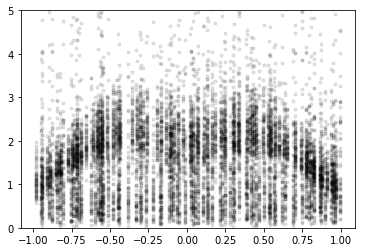

In [90]:
plt.plot(observation_index_points,np.exp(donepreds[-1,:,:].T),'k.',alpha=0.1);
plt.ylim([0,5])

(-10, 10)

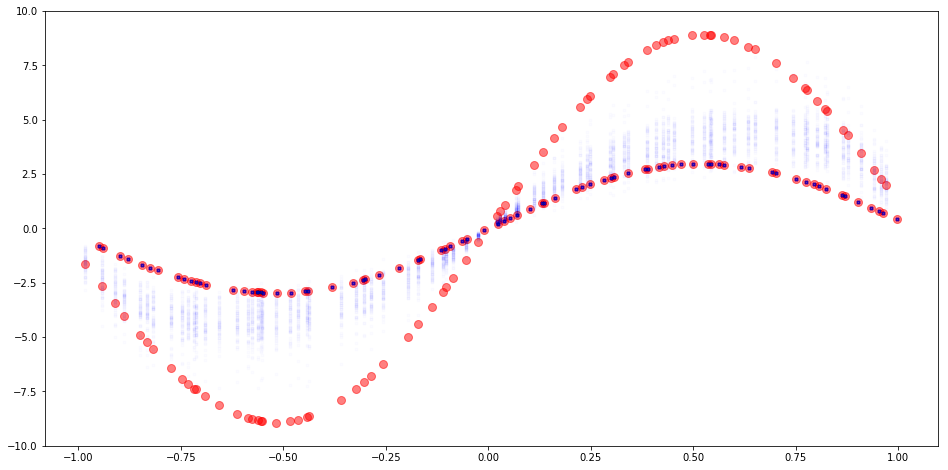

In [91]:
plt.figure(figsize=[16,8])
plt.plot(observation_index_points,observations[:,0],'r.',alpha=0.5,markersize=16)
donepreds[:,:,observations[:,1]==0]=0.0
#plt.plot(observations[:,0]/np.exp(donepreds[-1,0,:]),'b-')
##plt.plot(observation_index_points,np.mean(observations[:,0]/np.exp(donepreds[-1,:,:]),axis=0),'k-',lw=1,alpha=0.5)
plt.plot(observation_index_points,observations[:,0:1]/np.exp(donepreds[-1,:,:]).T,'b.',alpha=0.01)
plt.ylim([-10,10])
#plt.plot(observations[:,0]/np.exp(preds[0,0,:]),'k-')

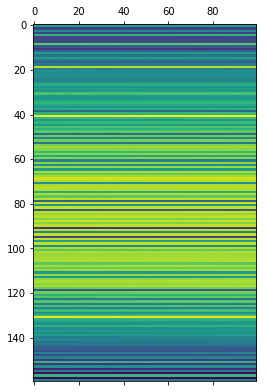

In [81]:
plt.matshow(preds.numpy()[::10,0,:].T)